Ciudad: Tarija, BO  |  lat=-21.5350, lon=-64.7290
POWER hourly OK (UTC): 2025-10-04 01:00 → 2025-10-06 00:00  (backoff=2h)


,T2M,WS10M,RH2M,PRECTOTCORR
datetime,,,,
2025-10-05 20:00:00+00:00,NaN,NaN,NaN,NaN
2025-10-05 21:00:00+00:00,NaN,NaN,NaN,NaN
2025-10-05 22:00:00+00:00,NaN,NaN,NaN,NaN
2025-10-05 23:00:00+00:00,NaN,NaN,NaN,NaN
2025-10-06 00:00:00+00:00,NaN,NaN,NaN,NaN


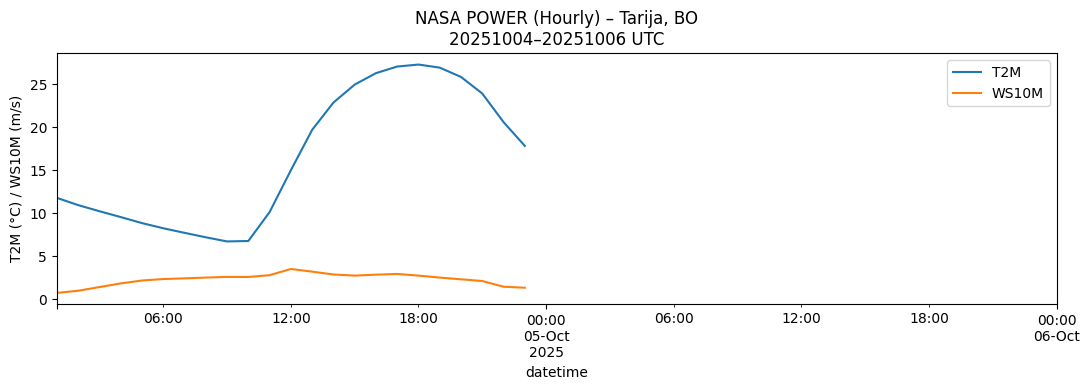

Serie guardada: nasa_power_hourly.png
✅ Mapa guardado: firms_map.png  (y firms_map.html)

Pie sugerido:
 Data source: NASA FIRMS (24h) & NASA POWER (UTC: 2025-10-04 01:00→2025-10-06 00:00) — Ciudad: Tarija, BO.
Guardado en: datasource_caption.txt


In [14]:
!pip -q install folium pandas requests matplotlib pillow selenium
!apt-get -yqq install chromium-chromedriver > /dev/null

import numpy as np, pandas as pd, requests, folium, matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from IPython.display import display
from PIL import Image
import os, time

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Parámetros
CITY = "Tarija, BO"
lat, lon = -21.5350, -64.7290
HOURS_WINDOW = 48
BACKOFF_HOURS = (2, 4, 6, 12, 18, 24)

# Utilidades
def _clean_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").replace({-999: np.nan, -888: np.nan})
    return df

def fetch_power_hourly(lat, lon, hours_window=48, backoff_hours=(2,4,6,12)):
    base_now = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
    for boff in backoff_hours:
        end_hour = base_now - timedelta(hours=boff)
        start_hour = end_hour - timedelta(hours=hours_window-1)
        start_str, end_str = start_hour.strftime("%Y%m%d"), end_hour.strftime("%Y%m%d")

        params = {
            "parameters": "T2M,WS10M,RH2M,PRECTOTCORR",
            "community": "RE",
            "longitude": lon, "latitude": lat,
            "start": start_str, "end": end_str,
            "time-standard": "UTC", "format": "JSON"
        }
        url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
        try:
            r = requests.get(url, params=params, timeout=30)
            r.raise_for_status()
            p = r.json()["properties"]["parameter"]
            # Unir claves por si alguna variable falta en alguna hora:
            keys = set()
            for k in ["T2M","WS10M","RH2M","PRECTOTCORR"]:
                keys |= set(p.get(k, {}).keys())
            idx = sorted(keys)
            if not idx:
                continue

            def g(dic, k):
                return dic.get(k) if dic and (k in dic) else np.nan

            df = pd.DataFrame({
                "datetime": pd.to_datetime(idx, format="%Y%m%d%H", utc=True),
                "T2M": [g(p.get("T2M"), k) for k in idx],
                "WS10M": [g(p.get("WS10M"), k) for k in idx],
                "RH2M": [g(p.get("RH2M"), k) for k in idx],
                "PRECTOTCORR": [g(p.get("PRECTOTCORR"), k) for k in idx],
            }).set_index("datetime")

            df = _clean_numeric(df, ["T2M","WS10M","RH2M","PRECTOTCORR"])
            df = df.loc[(df.index >= start_hour) & (df.index <= end_hour)]

            if df.dropna(how="all").empty:
                continue
            return df, {"start_hour": start_hour, "end_hour": end_hour, "backoff": boff}
        except Exception:
            continue
    return None, None

def fetch_power_daily(lat, lon, days=10):
    end_day = datetime.now(timezone.utc).date() - timedelta(days=1)   # último día completo
    start_day = end_day - timedelta(days=days-1)
    start_str, end_str = start_day.strftime("%Y%m%d"), end_day.strftime("%Y%m%d")
    params = {
        "parameters": "T2M,WS10M,RH2M,PRECTOTCORR",
        "community": "RE",
        "longitude": lon, "latitude": lat,
        "start": start_str, "end": end_str,
        "time-standard": "UTC", "format": "JSON"
    }
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    p = r.json()["properties"]["parameter"]

    keys = set()
    for k in ["T2M","WS10M","RH2M","PRECTOTCORR"]:
        keys |= set(p.get(k, {}).keys())
    idx = sorted(keys)

    def g(dic, k):
        return dic.get(k) if dic and (k in dic) else np.nan

    df = pd.DataFrame({
        "date": pd.to_datetime(idx, format="%Y%m%d", utc=True),
        "T2M": [g(p.get("T2M"), k) for k in idx],
        "WS10M": [g(p.get("WS10M"), k) for k in idx],
        "RH2M": [g(p.get("RH2M"), k) for k in idx],
        "PRECTOTCORR": [g(p.get("PRECTOTCORR"), k) for k in idx],
    }).set_index("date")

    df = _clean_numeric(df, ["T2M","WS10M","RH2M","PRECTOTCORR"])
    return df, {"start_day": start_day, "end_day": end_day}

def save_folium_png(html_path, png_path, width=1024, height=768, wait=1.5):
    opts = Options()
    opts.add_argument("--headless=new")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument(f"--window-size={width},{height}")
    driver = webdriver.Chrome(options=opts)
    try:
        driver.get("file://" + os.path.abspath(html_path))
        time.sleep(wait)
        driver.save_screenshot(png_path)
    finally:
        driver.quit()

    img = Image.open(png_path)
    img.save(png_path)

print(f"Ciudad: {CITY}  |  lat={lat:.4f}, lon={lon:.4f}")

# Serie POWER (grafica + PNG)
df_hourly, meta_h = fetch_power_hourly(lat, lon, HOURS_WINDOW, BACKOFF_HOURS)
caption_core = ""

if df_hourly is not None:
    sh, eh = meta_h["start_hour"], meta_h["end_hour"]
    print(f"POWER hourly OK (UTC): {sh:%Y-%m-%d %H:00} → {eh:%Y-%m-%d %H:00}  (backoff={meta_h['backoff']}h)")
    display(df_hourly.tail())

    ax = df_hourly[["T2M","WS10M"]].plot(figsize=(11,4))
    ax.set_title(f"NASA POWER (Hourly) – {CITY}\n{sh:%Y%m%d}–{eh:%Y%m%d} UTC")
    ax.set_ylabel("T2M (°C) / WS10M (m/s)")
    plt.tight_layout()
    plt.savefig("nasa_power_hourly.png", dpi=160)
    plt.show()
    series_png = "nasa_power_hourly.png"
    caption_core = f"NASA POWER (UTC: {sh:%Y-%m-%d %H:00}→{eh:%Y-%m-%d %H:00})"
else:
    print("POWER hourly sin datos válidos; usando POWER diario…")
    df_daily, meta_d = fetch_power_daily(lat, lon, days=10)
    display(df_daily.tail())

    ax = df_daily[["T2M","WS10M"]].plot(figsize=(11,4), marker="o")
    ax.set_title(f"NASA POWER (Daily) – {CITY}\n{meta_d['start_day']}–{meta_d['end_day']} UTC")
    ax.set_ylabel("T2M (°C) / WS10M (m/s)")
    plt.tight_layout()
    plt.savefig("nasa_power_daily.png", dpi=160)
    plt.show()
    series_png = "nasa_power_daily.png"
    caption_core = f"NASA POWER (UTC: {meta_d['start_day']}→{meta_d['end_day']})"

print(f"Serie guardada: {series_png}")

# B) Mapa FIRMS (HTML + PNG)
m = folium.Map(location=[lat, lon], zoom_start=7, tiles="CartoDB positron", control_scale=True)
folium.Marker([lat, lon], tooltip=CITY, icon=folium.Icon(color="red", icon="info-sign")).add_to(m)

for name, url in [
    ("FIRMS VIIRS (24h)", "https://firms.modaps.eosdis.nasa.gov/wmts/viirs/VIIRS_SNPP_NRT/Fire_Active/1.0.0/VIIRS_SNPP_NRT_Fire_Active/default/GoogleMapsCompatible_Level8/{z}/{y}/{x}.png"),
    ("FIRMS MODIS (24h)", "https://firms.modaps.eosdis.nasa.gov/wmts/MODIS_NRT/MODIS_Terra_Aqua_NRT/Fire_Active/1.0.0/MODIS_Terra_Aqua_NRT_Fire_Active/default/GoogleMapsCompatible_Level8/{z}/{y}/{x}.png"),
]:
    folium.raster_layers.TileLayer(tiles=url, name=name, attr="NASA FIRMS", overlay=True, control=True, opacity=0.85).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

html_map = "firms_map.html"
png_map  = "firms_map.png"
m.save(html_map)
save_folium_png(html_map, png_map, width=1280, height=900, wait=2.5)
print(f"✅ Mapa guardado: {png_map}  (y {html_map})")

#C) Pie de figura sugerido
caption = f"Data source: NASA FIRMS (24h) & {caption_core} — Ciudad: {CITY}."
print("\nPie sugerido:\n", caption)
with open("datasource_caption.txt", "w", encoding="utf-8") as f:
    f.write(caption)
print("Guardado en: datasource_caption.txt")